In [1]:
%matplotlib inline
import sys
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
from get_data import Data, DistilbertData, RawBertData

# relative score
RELATIVE = True

In [2]:
palette = {
    'orange': '#ff7f00',
    'green': '#4daf4a',
    'blue': '#377eb8',
    'red': '#e41a1c',
    'brown': '#452600',
    'yellow': '#ffd92f',
}
colors = {
    'two_stage': palette['green'],
    'all': palette['blue'],
    'alternate': palette['orange'], 'alternate': palette['orange'],
    'alternate-lte': palette['blue'], 'alternate-lte': palette['blue'],
    'self_distil': palette['blue'],
    'limit': palette['brown'],
}

In [3]:
def get_ref_acc(model, routine='two_stage'):
    # get the 100% score for RELATIVE
    acc = {}
    for dataset in datasets:
        data_obj = Data(model, dataset, routine, testset=testset)
        acc[dataset] = data_obj.layer_acc[-1]
    return acc


def plot_acc_by_layer(axis, data, ref_acc):
    axis.set_xlim(1, data.size)

    if data.routine.endswith('lte'):
        # lte acc
        x, y = data.etp_acc
        if RELATIVE:
            y = list(map(lambda x: 100*x/ref_acc[dataset], y))
        axis.plot(x, y, 'o-', color=colors[data.routine],
                  linewidth=1, markersize=3,
                  label='\\textsc{' + data.formal_routine + '}'
                  )
    else:
        # layer-wise acc
        if (
                (plot_target == 0 and data.routine != 'limit') or
#                 (plot_target == 1 and data.routine == 'limit') or
                (plot_target in [2, 3])
        ):
            y = data.layer_acc
            if RELATIVE:
                y = list(map(lambda x: 100*x/ref_acc[dataset], y))
            color = colors[data.routine]
            if plot_target == 3 and data.model == 'bert-large':
                top = ref_acc[data.dataset]
                bot = y[11]
                # print(bot, top)
                color = palette['blue']
                axis.add_patch(mpatches.FancyArrowPatch(
                    posA=[12, bot], posB=[12, top],
                    arrowstyle=mpatches.ArrowStyle.CurveAB(head_length=4, head_width=4),
                    color='r',
                ))
                axis.text(
                    x=12+0.5, y=bot-1.5,
                    s='Diff = ${:.1f}$'.format(top-bot),
                )
            lw = 1
            if plot_target == 0 and model in ['roberta-base', 'albert-base']:
                lw = 1
            axis.plot(range(1, 1+len(data.layer_acc)), y,
                      'o-', color=color,
                      label='\\textsc{' + data.formal_routine + '}',
                      linewidth=lw, markersize=3)

        # entropy-based acc
        if plot_target == 1 and data.routine != 'limit':
            color = colors[data.routine]
            label = '\\textsc{' + data.formal_routine + '}'
            if data.model != model:
                color = palette['green']
                label = '\\textsc{db+alt}'
            x, y = data.etp_acc
            if RELATIVE:
                y = list(map(lambda x: 100*x/ref_acc[dataset], y))
            axis.plot(x, y, 'o-', color=color,
                      label=label,
                      linewidth=1, markersize=3)
            if data.model.startswith('distil'):
                axis.scatter(max(x), max(y), s=100, marker='P', c=color)

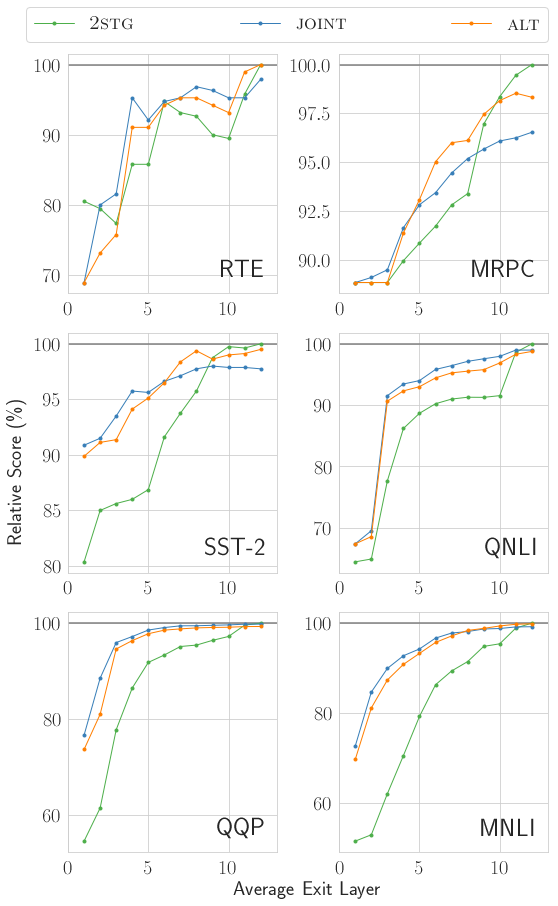

In [4]:
# Input arguments
model = 'bert-base'
plot_target = 0
testset = False

model_formal_name = {
    'bert': 'BERT',
    'roberta': 'RoBERTa',
    'albert': 'ALBERT',
    'distilbert': 'DistilBERT',
}
plot_target_name = [
    'routine_comp',  # comparison between different training routines
    'layer_etp_acc_comp',  # comparison between layer_acc and etp_acc
    'layer_lte_acc_comp',  # comparison between layer_acc and lte
    'limit_comp',  # comparison between bert-base and bert-large's limit
]

# default style
sns.set_style('whitegrid')
matplotlib.rc('font', size=20)
matplotlib.rc('text', usetex=True)

columns = 2

original_model = model
dual_model = False
if plot_target == 0:
    routines = ['two_stage', 'all', 'alternate']
    if model in ['bert-base']:
        datasets = ['RTE', 'MRPC', 'SST-2', 'QNLI', 'QQP', 'MNLI']
    elif model in ['rna-base']:
        datasets = ['RTE', 'MRPC', 'RTE', 'MRPC']
        dual_model = ['roberta-base', 'roberta-base',
                      'albert-base', 'albert-base']
    elif model in ['roberta-base', 'albert-base']:
        # appendix
        datasets = ['SST-2', 'QNLI', 'QQP', 'MNLI']
    elif model in ['bnr-large']:
        # appendix
        datasets = ['MRPC', 'MRPC', 'SST-2', 'SST-2', 'MNLI', 'MNLI']
        routines = ['two_stage', 'alternate', 'self_distil']
        dual_model = ['bert-large', 'roberta-large',
                      'bert-large', 'roberta-large',
                      'bert-large', 'roberta-large']

elif plot_target == 1:
    routines = ['all', 'alternate', 'limit']
    if model in ['bert-base']:
        datasets = ['RTE', 'MRPC', 'SST-2', 'QNLI', 'QQP', 'MNLI']
    elif model in ['rna-base']:
        datasets = ['RTE', 'MRPC', 'RTE', 'MRPC']
        dual_model = ['roberta-base', 'roberta-base',
                      'albert-base', 'albert-base']

elif plot_target == 2:
    assert model == 'bert-base'
    routines = ['alternate', 'alternate-lte']
    datasets = ['QNLI', 'QQP', 'STS-B', 'SICK']

elif plot_target == 3:
    assert model == 'bert-bnl'
    routines = ['limit', 'limit']
    datasets = ['MRPC', 'QNLI']
    RELATIVE = False


M, N = len(datasets)//columns, columns
axes_width = 4
axes_height = 4
if plot_target == 3:
    # without legend
    legend_height = 0
elif plot_target == 0 and model in ['roberta-base', 'albert-base', 'bnr-large']:
    axes_height = 3
    legend_height = 0.8
else:
    legend_height = 0.8
sizes = [N*axes_width, M*axes_height+legend_height]
fig, axes = plt.subplots(M, N, figsize=sizes)
axes = axes.reshape([-1])


# distilbert_data = DistilbertData()
for i_dataset, dataset in enumerate(datasets):
    if dual_model:
        model = dual_model[i_dataset]

    if RELATIVE:
        ref_acc = get_ref_acc(model)
    else:
        ref_acc = {}
    dataset_axis = axes[i_dataset]

    for i_routine, routine in enumerate(routines):
        if plot_target == 3:
            model = 'bert-base' if i_routine%2 == 0 else 'bert-large'
            ref_acc = get_ref_acc('bert-base', 'limit')
        try:
            data_obj = Data(model, dataset, routine, testset=testset)
            plot_acc_by_layer(
                dataset_axis,
                data_obj,
                ref_acc
            )
            if model == 'bert-base' and plot_target == 1 and routine == 'alternate':
                db_data_obj = Data('distilbert-base', dataset, routine, testset=testset)
                plot_acc_by_layer(
                    dataset_axis,
                    db_data_obj,
                    ref_acc
                )
        except FileNotFoundError:
            pass

    try:
        dataset_axis.set_xlim(0, data_obj.size+1)

        if i_dataset == 0 and plot_target != 3:
            dataset_axis.legend(
                bbox_to_anchor=(-0.2, 0.85+legend_height/axes_height, 2.5, 0.1),
                # xoffset, yoffset, width, height
                bbox_transform=dataset_axis.transAxes,
                # the unit of bbox will be proportion of axes
                loc='lower left',
                ncol=5,  # larger than needed
                mode='expand',
                borderaxespad=0.,
                prop={'weight': 'bold'},
                fontsize=15)

        model_name, model_size = model.split('-')
        model_name = model_formal_name[model_name]
        model_size = '\\textsubscript{\\textsc{' + model_size + '}}'
#         dataset_axis.set_title(
#             ('' if plot_target==3 else model_name + model_size + ' : ') \
#             + datasets[i_dataset]
#         )
#         dataset_axis.set_xlabel(
#             ('Avg. ' if plot_target in [1, 2] else '') +
#             'Exit layer'
#         )
#         dataset_axis.set_ylabel(('Relative ' if RELATIVE else '') + 'Score (\\%)')
        dataset_axis.text(0.95, 0.05, datasets[i_dataset],
                          fontsize=25,
                          ha='right', va='bottom', transform=dataset_axis.transAxes)
        if plot_target <=1 and model in ['bert-base', 'rna-base'] :
            dataset_axis.hlines(y=100, xmin=0, xmax=13, colors='grey')
        if plot_target == 3:
            dataset_axis.set_xticks([6, 12, 18, 24])
            dataset_axis.set_xticklabels([6, 12, 18, 24])
            dataset_axis.set_ylim(bottom=75)
        if plot_target == 0 and original_model in ['roberta-base', 'albert-base']:
            dataset_axis.set_ylim(35, 105)
    except NameError:
        pass

fig.text(0.53, 0.01, 'Average Exit Layer',
         ha='center')
fig.text(0.01, 0.47, ('Relative ' if RELATIVE else '') + 'Score (\\%)',
         va='center', rotation=90)

plt.tight_layout(pad=1.3, h_pad=0.5, w_pad=0.5)
plt.savefig(f'figs/{original_model}-{plot_target_name[plot_target]}.pdf')